# Adding a J2

In [1]:
import rebound
sim = rebound.Simulation()
sim.add(m=1., hash="star") # Sun
sim.add(m=1.e-5,a=1,e=1.e-2, hash="planet")
sim.move_to_com()
ps = sim.particles

sim.integrate(1.)
print("pomega = %.16f"%sim.particles[1].pomega)

pomega = 0.0000000000000000


As expected, the pericenter did not move at all.  Now let's add a J2 and J4

In [2]:
import reboundx
rebx = reboundx.Extras(sim)
rebx.add("gravitational_harmonics")

In [3]:
ps["star"].params["J2"] = 0.1
ps["star"].params["J4"] = 0.2
ps["star"].params["R_eq"] = 1/200.

Now we integrate as normal:

In [5]:
import numpy as np
tmax = 1.e4
Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)
pomegas = np.zeros(Nout)
Eerr = np.zeros(Nout)
E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)

for i, time in enumerate(times):
    sim.integrate(time)
    Ef = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
    pomegas[i] = ps["planet"].pomega
    Eerr[i] = abs(Ef-E0)/abs(E0)
print("pomega = {0}".format(ps[1].pomega))
print("Relative energy error = {0}".format(Eerr[-1]))

pomega = 0.037037080330987265
Relative energy error = 3.3881231820970424e-16


Let's test that the precession rate matches the predicted rate:

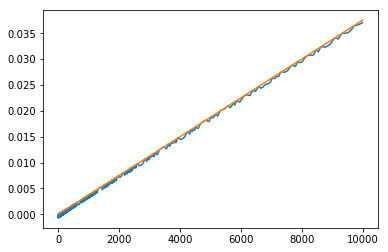

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
predrate = ps["planet"].n*(1.5*ps["star"].params["J2"]*(ps["star"].params["R_eq"]/ps["planet"].a)**2 - 15/4*ps["star"].params["J4"]*(ps["star"].params["R_eq"]/ps["planet"].a)**4)
predpomega = [predrate*time for time in times]

fig, ax = plt.subplots()
ax.plot(times, pomegas)
ax.plot(times, predpomega)

and check that the energy error remains at machine precision:

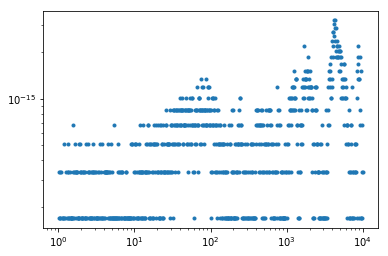

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times, Eerr, '.')
ax.set_xscale('log')
ax.set_yscale('log')